## In development - Workflow of drift analysis

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cesnet_datazoo.datasets import CESNET_TLS_Year22
from cesnet_datazoo.config import DatasetConfig, AppSelection
from datetime import datetime, timedelta


from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

from scipy import stats
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore') 

Create reference classifier from the first week of data

In [12]:
data = CESNET_TLS_Year22("/home/dosoukup/Dataset/Thesis_contents/testing/datasets/TLS/", size="XS")
common_params = {
    "dataset": data,
    "train_period_name": "W-2022-1",
    "apps_selection": AppSelection.ALL_KNOWN,
    "use_packet_histograms": True,
}

hist_df = pd.DataFrame()
current_date = datetime(2022, 1, 1)
while current_date <= datetime(2022, 1, 7):
    dataset_config = DatasetConfig(**common_params, test_period_name=current_date.strftime("M-%Y-%m"), test_dates=[current_date.strftime("%Y%m%d")])
    data.set_dataset_config_and_initialize(dataset_config)
    curr_df = data.get_test_df(flatten_ppi=True)
    curr_sample = curr_df.sample(10000, random_state = 42, replace=True)
    curr_sample["date"] = current_date
    hist_df = pd.concat([hist_df,curr_sample])
    current_date += timedelta(days=1)

Xdata = hist_df.drop(columns=["APP","date"])
ydata = hist_df.APP
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.33, random_state=42)

ref_clf = XGBClassifier().fit(X_train, y_train)
y_pred = ref_clf.predict(X_test)

print(f"F1 Score: {f1_score(y_test, y_pred, average = 'weighted')}")

Loading data from dataloader


100%|██████████| 5/5 [00:00<00:00, 25.59it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 21.39it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 31.86it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 29.71it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 34.18it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 25.00it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 26.58it/s]


F1 Score: 0.9001427150337031


In [13]:
from detector.detector import DriftDetector, Config
from detector.logger import Logger
from detector.test import KSTest, WassersteinTest
from detector.analyser import LastWeekAnalyser

feat_names = [col for col in ref_clf.feature_names_in_ if "FLOW_" not in col and  "week" not in col]

global_config = Config(
    chosen_features = feat_names,
    feature_importances = pd.Series(ref_clf.feature_importances_,index = ref_clf.feature_names_in_),
    drift_test=WassersteinTest(drift_threshold_global=0.05,drift_threshold_single = 0.1)
)

class_config = Config(
    chosen_features = feat_names,
    feature_importances = pd.Series(ref_clf.feature_importances_,index = ref_clf.feature_names_in_),
    #drift_test=WassersteinTest(drift_threshold_global=0.05,drift_threshold_single = 0.1),
    drift_test=KSTest(drift_threshold_global=0.475, drift_threshold_single = 0.05),
    class_name="APP"
)

analyser_config = Config(
    chosen_features = feat_names,
    feature_importances = pd.Series(ref_clf.feature_importances_,index = ref_clf.feature_names_in_),
    drift_test=WassersteinTest(drift_threshold_global=0.04)
)

#Logger of the single reference model without retraining
logger_ref = Logger()
analyser_ref = LastWeekAnalyser(analyser_config)
detector_ref = DriftDetector(global_config, class_config, logger=logger_ref, analyser=analyser_ref)

#Loggers for the retrained models
logger_drift = Logger()
analyser_drift = LastWeekAnalyser(analyser_config)
detector_drift = DriftDetector(global_config, class_config, logger=logger_drift, analyser=analyser_drift)

test_data = CESNET_TLS_Year22("/home/dosoukup/Dataset/Thesis_contents/testing/datasets/TLS/", size="XS")
common_params = {
    "dataset": test_data,
    "train_period_name": "W-2022-1",
    "use_packet_histograms": True,
}

f1_no_retraining = []
f1_drift_retraining = []

retraining_clf = ref_clf
old_clf = None

ref_df = hist_df.copy()

analysis_df = pd.DataFrame()
feature_drift_df = pd.DataFrame()
class_drift_df = pd.DataFrame()

ret_feature_drift_df = pd.DataFrame()
ret_class_drift_df = pd.DataFrame()

current_date = datetime(2022, 1, 8)
while current_date <= datetime(2022, 12, 31):
    try:
    #if(True):
        #Get current data
        dataset_config = DatasetConfig(**common_params, test_period_name=current_date.strftime("M-%Y-%m"), test_dates=[current_date.strftime("%Y%m%d")])
        test_data.set_dataset_config_and_initialize(dataset_config)
        test_df = test_data.get_test_df(flatten_ppi=True)

        #Test model with no retraining
        Xdata = test_df.drop(columns=["APP"])
        ydata = test_df.APP
        y_pred_ref = ref_clf.predict(Xdata)
        f1_no_retraining.append(f1_score(ydata,y_pred_ref, average = 'weighted'))     
        detector_ref.detect(ref_df,test_df,current_date,f1 = f1_score(ydata,y_pred_ref, average = 'weighted'))

        #Test retraining model
        y_pred = retraining_clf.predict(Xdata)
        f1_drift_retraining.append(f1_score(ydata,y_pred, average = 'weighted'))     
        is_drifted = detector_drift.detect(hist_df,test_df,current_date,f1 = f1_score(ydata,y_pred, average = 'weighted'))

        #Store predictions in analysis data frame
        tmp_df = test_df.copy()
        tmp_df["date"] = current_date
        tmp_df["ref_pred"] = y_pred_ref
        tmp_df["retrain_pred"] = y_pred
        analysis_df = pd.concat([analysis_df,tmp_df])

        #Store additional test results for analysis
        feature_drift_df = pd.concat([feature_drift_df, detector_ref.get_drifted_features().to_frame().T])
        class_drift_df = pd.concat([class_drift_df, detector_ref.get_class_drift().drift_strength.to_frame().T])
        ret_feature_drift_df = pd.concat([ret_feature_drift_df, detector_drift.get_drifted_features().to_frame().T])
        ret_class_drift_df = pd.concat([ret_class_drift_df, detector_drift.get_class_drift().drift_strength.to_frame().T])

        #Retrain the model if drift was detected
        if is_drifted:
            print("Drift detected, retraining")

            #Update training dataset
            hist_df = hist_df.tail(len(hist_df)-len(test_df))
            test_df["date"] = current_date
            hist_df = pd.concat([hist_df,test_df])
            Xdata = hist_df.drop(columns=["APP","date"])
            ydata = hist_df.APP
            retraining_clf = XGBClassifier().fit(Xdata, ydata)

    except Exception as error:
        print("An error occurred:", error)
        print(f"{current_date} missing from the dataset")
    current_date += timedelta(days=1)

Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 38.47it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 28.75it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 28.73it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 37.30it/s]


Loading data from dataloader


100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 44.46it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 43.39it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 20.69it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 24.63it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 47.08it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.52it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 48.02it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 48.91it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 42.27it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 35.42it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 43.41it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 30.48it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


Loading data from dataloader


100%|██████████| 4/4 [00:00<00:00, 22.97it/s]


An error occurred: 1 validation error for DatasetConfig
  Value error, Bad test dates ['20220128']. Use dates available in dataset.available_dates (collection period 1.1.2022 - 31.12.2022). These dates are missing from the dataset collection period ['20220128', '20220129', '20220130', '20221212', '20221213', '20221229', '20221230', '20221231'] [type=value_error, input_value=ArgsKwargs((), {'dataset'...t_dates': ['20220128']}), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.6/v/value_error
2022-01-28 00:00:00 missing from the dataset
An error occurred: 1 validation error for DatasetConfig
  Value error, Bad test dates ['20220129']. Use dates available in dataset.available_dates (collection period 1.1.2022 - 31.12.2022). These dates are missing from the dataset collection period ['20220128', '20220129', '20220130', '20221212', '20221213', '20221229', '20221230', '20221231'] [type=value_error, input_value=ArgsKwargs((), {'dataset'...t_dates': ['2022

100%|██████████| 5/5 [00:00<00:00, 26.69it/s]


An error occurred: Distribution can't be empty.
2022-01-31 00:00:00 missing from the dataset
Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 35.41it/s]


An error occurred: Distribution can't be empty.
2022-02-01 00:00:00 missing from the dataset
Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 50.28it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 53.81it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 48.08it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 34.06it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 20.89it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 51.93it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 57.57it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 56.33it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 57.92it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 50.95it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 36.80it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 47.25it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 46.09it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 63.28it/s]


Loading data from dataloader


100%|██████████| 23/23 [00:00<00:00, 57.69it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 35.36it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 47.85it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 24.78it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 29.77it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 41.33it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 50.14it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 45.18it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 43.83it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 28.73it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 40.20it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 39.07it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 39.37it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 54.61it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 61.72it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 54.50it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 34.74it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 37.24it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 26.28it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 57.89it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 60.75it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 53.24it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 56.45it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 57.92it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 39.20it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 44.74it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 59.27it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 38.43it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 45.16it/s]


Loading data from dataloader


100%|██████████| 23/23 [00:00<00:00, 44.62it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 62.40it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 42.04it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 44.25it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 69.13it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 51.65it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 67.95it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 66.92it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 60.85it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 44.86it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 37.04it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 56.32it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 60.69it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 38.54it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 45.72it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 57.72it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 39.91it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 26.49it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 52.46it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 34.76it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 36.94it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 60.56it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 55.29it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 40.81it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 23.39it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 49.66it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 45.24it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 38.45it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 46.21it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 27.77it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 30.84it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 38.25it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 37.54it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 55.52it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 49.76it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 65.45it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 49.31it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 42.28it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 37.59it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 67.08it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 63.99it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 63.36it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 65.65it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 60.85it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 21.46it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 45.29it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 57.82it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 63.02it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 55.05it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 65.63it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 56.92it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 37.72it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 39.13it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 64.38it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 64.03it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 64.14it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 66.57it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 58.89it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 44.38it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 44.25it/s]


Loading data from dataloader


100%|██████████| 23/23 [00:00<00:00, 58.30it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 65.75it/s]


Loading data from dataloader


100%|██████████| 23/23 [00:00<00:00, 60.29it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 56.62it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 56.80it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 36.31it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 45.50it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 64.36it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 61.93it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 63.00it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 60.65it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 49.73it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 40.46it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 38.35it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 62.33it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 57.18it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 58.00it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 54.38it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 56.31it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 42.61it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 20.48it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 58.99it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 46.70it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 54.56it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 61.31it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 60.27it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 39.87it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 40.27it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 59.50it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 63.63it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 61.17it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 54.49it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 53.94it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 31.67it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 37.38it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 64.16it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 63.10it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 45.92it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 59.57it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 58.08it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 43.89it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 39.11it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 61.34it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 59.69it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 57.84it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 55.69it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.63it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 43.53it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 35.95it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 46.81it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 44.36it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 44.59it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 53.23it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 48.79it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 35.29it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 32.71it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 52.42it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 58.02it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 53.51it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 55.09it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 48.06it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 38.42it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 37.24it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 55.13it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 49.77it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 55.36it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 51.49it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 44.28it/s]


Loading data from dataloader


100%|██████████| 5/5 [00:00<00:00, 31.61it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 36.64it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 52.58it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.21it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 49.86it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 53.45it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 46.17it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 38.92it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 34.95it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 49.53it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.21it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 47.94it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 52.48it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 45.90it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 35.35it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 37.02it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 48.84it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 51.45it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.18it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.00it/s]


Drift detected, retraining
An error occurred: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155], got [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61 

100%|██████████| 11/11 [00:00<00:00, 52.10it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 37.87it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 35.28it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 51.38it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 49.06it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 53.29it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 49.31it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 51.42it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 34.97it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 36.74it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 51.58it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 52.08it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 54.77it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 53.72it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 53.35it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 38.18it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 36.56it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 54.47it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 56.61it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 55.49it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 53.29it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.99it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 38.64it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 38.10it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 57.37it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 58.78it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 56.18it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 57.66it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 54.27it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 36.00it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 33.42it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 55.87it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 58.17it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 60.33it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 55.36it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 56.86it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 36.13it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 34.32it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 58.49it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 60.29it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 60.32it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 55.49it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 55.82it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 39.46it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 35.83it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 56.31it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 59.81it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 44.74it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 56.18it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 55.87it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 40.09it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 44.09it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 63.63it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 62.83it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 60.37it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 60.62it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 52.79it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 34.31it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 36.43it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 59.65it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 62.50it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 59.64it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 59.60it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 54.17it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 41.37it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 43.27it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 60.92it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 60.78it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 66.19it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 64.33it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 57.82it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 41.18it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 45.40it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 61.79it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 57.43it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 59.49it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 53.80it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 34.20it/s]


Loading data from dataloader


100%|██████████| 5/5 [00:00<00:00, 31.52it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 42.32it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 57.02it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 62.38it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 60.06it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 61.33it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 56.87it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 37.35it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 40.81it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 66.35it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 61.79it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 61.39it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 63.79it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 54.94it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 35.21it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 13.34it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 62.56it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 63.45it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 60.66it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 42.83it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 49.10it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 41.35it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 44.31it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 61.66it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 62.48it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 63.05it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 61.66it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 58.49it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 39.31it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 44.22it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 57.54it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 62.19it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 63.08it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 60.41it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 55.44it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 39.23it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 44.43it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 58.14it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 63.14it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 64.19it/s]


Loading data from dataloader


100%|██████████| 18/18 [00:00<00:00, 58.52it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 52.27it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 40.70it/s]


Loading data from dataloader


100%|██████████| 5/5 [00:00<00:00, 33.16it/s]


An error occurred: 1 validation error for DatasetConfig
  Value error, Bad test dates ['20221212']. Use dates available in dataset.available_dates (collection period 1.1.2022 - 31.12.2022). These dates are missing from the dataset collection period ['20220128', '20220129', '20220130', '20221212', '20221213', '20221229', '20221230', '20221231'] [type=value_error, input_value=ArgsKwargs((), {'dataset'...t_dates': ['20221212']}), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.6/v/value_error
2022-12-12 00:00:00 missing from the dataset
An error occurred: 1 validation error for DatasetConfig
  Value error, Bad test dates ['20221213']. Use dates available in dataset.available_dates (collection period 1.1.2022 - 31.12.2022). These dates are missing from the dataset collection period ['20220128', '20220129', '20220130', '20221212', '20221213', '20221229', '20221230', '20221231'] [type=value_error, input_value=ArgsKwargs((), {'dataset'...t_dates': ['2022

100%|██████████| 9/9 [00:00<00:00, 45.34it/s]


An error occurred: Distribution can't be empty.
2022-12-14 00:00:00 missing from the dataset
Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 55.52it/s]


An error occurred: Distribution can't be empty.
2022-12-15 00:00:00 missing from the dataset
Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 48.01it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 36.68it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 34.83it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 54.94it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 55.50it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 48.22it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 42.58it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 37.45it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 4/4 [00:00<00:00, 27.68it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 4/4 [00:00<00:00, 26.74it/s]


Loading data from dataloader


100%|██████████| 4/4 [00:00<00:00, 28.30it/s]


Drift detected, retraining
Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 36.27it/s]


Loading data from dataloader


100%|██████████| 3/3 [00:00<00:00, 23.61it/s]


An error occurred: 1 validation error for DatasetConfig
  Value error, Bad test dates ['20221229']. Use dates available in dataset.available_dates (collection period 1.1.2022 - 31.12.2022). These dates are missing from the dataset collection period ['20220128', '20220129', '20220130', '20221212', '20221213', '20221229', '20221230', '20221231'] [type=value_error, input_value=ArgsKwargs((), {'dataset'...t_dates': ['20221229']}), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.6/v/value_error
2022-12-29 00:00:00 missing from the dataset
An error occurred: 1 validation error for DatasetConfig
  Value error, Bad test dates ['20221230']. Use dates available in dataset.available_dates (collection period 1.1.2022 - 31.12.2022). These dates are missing from the dataset collection period ['20220128', '20220129', '20220130', '20221212', '20221213', '20221229', '20221230', '20221231'] [type=value_error, input_value=ArgsKwargs((), {'dataset'...t_dates': ['2022

In [ ]:
#display(logger_ref.get_logs(log_type="global")) # 0.05
#display(logger_ref.get_logs(log_type="class")) # drifted class 0.05
#display(logger_ref.get_logs(log_type="feature") > 0.1) # drifted feature

# Visualise global experiment result

In [21]:
import pickle
with open('logs-tls-ppi.pkl', 'wb') as outp:
    pickle.dump(logger_drift, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(logger_ref, outp, pickle.HIGHEST_PROTOCOL)

#with open('logs.pkl', 'rb') as inp:
#    logger_drift = pickle.load(inp)
#    logger_ref = pickle.load(inp)

In [23]:
with open('logs-tls-ppi.pkl', 'rb') as inp:
    logger_drift = pickle.load(inp)
    logger_ref = pickle.load(inp)

In [52]:
xx = logger_ref.get_logs()["is_drifted"]
yy =  logger_drift.get_logs()["is_drifted"]

In [60]:
pd.set_option('display.max_rows', 500)

False

In [62]:
xx

2022-01-08    False
2022-01-09    False
2022-01-10    False
2022-01-11    False
2022-01-12    False
2022-01-13    False
2022-01-14    False
2022-01-15    False
2022-01-16    False
2022-01-17    False
2022-01-18    False
2022-01-19    False
2022-01-20    False
2022-01-21    False
2022-01-22     True
2022-01-23    False
2022-01-24    False
2022-01-25    False
2022-01-26    False
2022-01-27    False
2022-02-01     True
2022-02-02     True
2022-02-03     True
2022-02-04     True
2022-02-05     True
2022-02-06     True
2022-02-07     True
2022-02-08    False
2022-02-09     True
2022-02-10     True
2022-02-11     True
2022-02-12     True
2022-02-13     True
2022-02-14     True
2022-02-15    False
2022-02-16    False
2022-02-17     True
2022-02-18    False
2022-02-19     True
2022-02-20    False
2022-02-21    False
2022-02-22    False
2022-02-23    False
2022-02-24    False
2022-02-25    False
2022-02-26     True
2022-02-27    False
2022-02-28     True
2022-03-01     True
2022-03-02    False


In [66]:
from detector.reporter import Reporter
reporter = Reporter([logger_drift,logger_ref], ["Retraining model", "Reference model"], chunk_length=7)
reporter.get_global_results()

Exception: The indexes of all experiments have to be the same

In [17]:
figure = reporter.plot_global_results(detection_threshold = 0.05,
    severity_style = [{"line": "dotted", "color": "blue", "alpha": 0.5},
                      {"line": "solid", "color": "blue", "alpha": 0.5}],
    f1_style = [{"line": "dotted", "color": "red", "alpha": 0.5},
                {"line": "solid", "color": "red", "alpha": 0.5}],
    detection_style = [{"line": "solid", "color": "y", "alpha": 0.5},
                       {"line": "dotted", "color": "cyan", "alpha": 0.25}]
)
plt.show()

NameError: name 'reporter' is not defined

Analysis results of Retraining model experiment:
Drift_type
No_drift             31
Unknown_drift         7
Periodic_drift        4
Incremental_drift     3
Sudden_drift          2
Name: count, dtype: int64


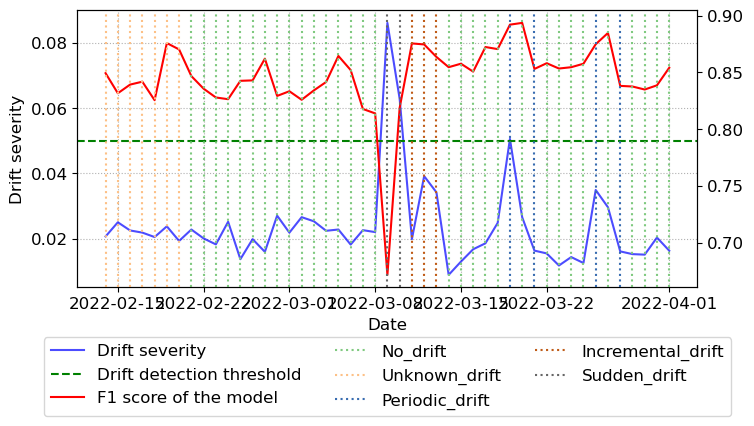

Analysis results of Reference model experiment:
Drift_type
No_drift             31
Unknown_drift         7
Periodic_drift        4
Incremental_drift     3
Sudden_drift          2
Name: count, dtype: int64


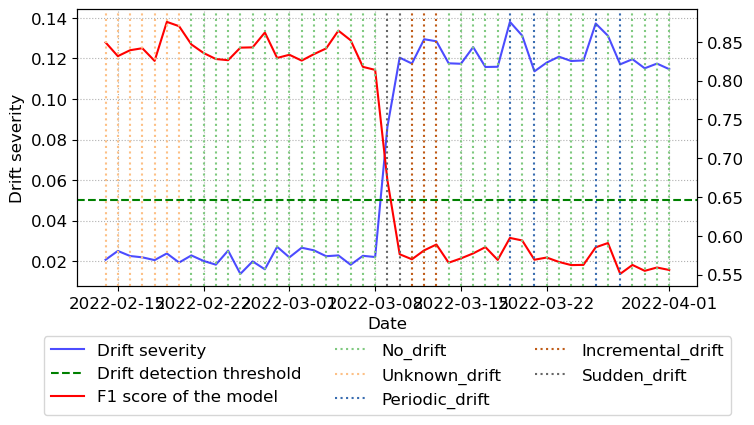

In [8]:
reporter.plot_analysis_results(detection_threshold = 0.05)

In [9]:
for r in reporter.get_chunk_results():
    display(r)

print("Sorted by ratio of drift detections")

for r in reporter.get_chunk_results(sort_by="Ratio_of_drift_detections", ascending = False):
    display(r)

,Ratio_of_drift_detections,Mean_drift_strength,Mean_ratio_of_drifted_features,Mean_f1_score
Chunk,,,,
0,0.000000,0.021933,0.000000,0.847732
1,0.000000,0.019384,0.000000,0.840695
2,0.000000,0.023449,0.003297,0.840199
3,0.285714,0.041000,0.032967,0.819489
4,0.142857,0.022722,0.023077,0.870280
5,0.000000,0.019269,0.002198,0.862404
6,0.000000,0.016599,0.000000,0.840737


,Ratio_of_drift_detections,Mean_drift_strength,Mean_ratio_of_drifted_features,Mean_f1_score
Chunk,,,,
0,0.000000,0.021933,0.000000,0.847732
1,0.000000,0.019384,0.000000,0.840695
2,0.000000,0.023449,0.003297,0.840199
3,0.714286,0.089527,0.190110,0.659919
4,1.000000,0.123087,0.296703,0.579835
5,1.000000,0.122669,0.306593,0.572543
6,1.000000,0.116815,0.280000,0.556611


Sorted by ratio of drift detections


,Ratio_of_drift_detections,Mean_drift_strength,Mean_ratio_of_drifted_features,Mean_f1_score
Chunk,,,,
3,0.285714,0.041000,0.032967,0.819489
4,0.142857,0.022722,0.023077,0.870280
0,0.000000,0.021933,0.000000,0.847732
1,0.000000,0.019384,0.000000,0.840695
2,0.000000,0.023449,0.003297,0.840199
5,0.000000,0.019269,0.002198,0.862404
6,0.000000,0.016599,0.000000,0.840737


,Ratio_of_drift_detections,Mean_drift_strength,Mean_ratio_of_drifted_features,Mean_f1_score
Chunk,,,,
4,1.000000,0.123087,0.296703,0.579835
5,1.000000,0.122669,0.306593,0.572543
6,1.000000,0.116815,0.280000,0.556611
3,0.714286,0.089527,0.190110,0.659919
0,0.000000,0.021933,0.000000,0.847732
1,0.000000,0.019384,0.000000,0.840695
2,0.000000,0.023449,0.003297,0.840199


# Examine fauture and class drift statistics

In [27]:
class_drift_df = logger_ref.get_logs(log_type="class")
feature_drift_df = logger_ref.get_logs(log_type="feature")
ret_class_drift_df = logger_drift.get_logs(log_type="class")
ret_feature_drift_df = logger_drift.get_logs(log_type="feature")
display(class_drift_df.head(50))
display(feature_drift_df.head())

,Class_0,Class_1,Class_10,Class_100,Class_101,Class_102,Class_103,Class_104,Class_105,Class_106,...,Class_90,Class_91,Class_92,Class_93,Class_94,Class_95,Class_96,Class_97,Class_98,Class_99
2022-01-08,0.898345,0.845363,0.491773,0.911374,0.897915,0.941974,0.452541,0.749502,0.802867,0.775565,...,0.913708,0.814841,0.795366,0.790776,0.944054,0.923175,0.835245,0.670456,0.562181,0.710516
2022-01-09,0.883531,0.788473,0.493380,0.663478,0.903901,0.939907,0.601560,0.714714,0.756602,0.725417,...,0.856118,0.897960,0.820659,0.915141,0.914783,0.894706,0.891099,0.816439,0.487247,0.619502
2022-01-10,0.689843,0.793899,0.260308,0.850183,0.881068,0.921485,0.331758,0.414458,0.702211,0.714502,...,0.720674,0.522243,0.751339,0.828143,0.891412,0.816358,0.729024,0.779757,0.548802,0.779396
2022-01-11,0.812219,0.802938,0.346574,0.784914,0.892822,0.938990,0.543193,0.551585,0.655903,0.493497,...,0.773527,0.852149,0.762482,0.822980,0.918216,0.854336,0.680546,0.768513,0.555032,0.827362
2022-01-12,0.866515,0.814088,0.403942,0.873323,0.910755,0.931586,0.615660,0.661715,0.821251,0.626594,...,0.887416,0.511747,0.745334,0.756634,0.945795,0.929578,0.746067,0.772217,0.628672,0.846445
2022-01-13,0.819832,0.748922,0.330632,0.910512,0.916304,0.896480,0.503251,0.681731,0.585719,0.674159,...,0.781080,0.589405,0.740325,0.747916,0.800169,0.762022,0.706820,0.720183,0.453988,0.836860
2022-01-14,0.812615,0.798750,0.603170,0.755830,0.904073,0.912600,0.539001,0.810731,0.682882,0.641498,...,0.903562,0.793525,0.652202,0.807244,0.884184,0.872160,0.836735,0.851378,0.595288,0.870153
2022-01-15,0.900426,0.813684,0.568144,0.869112,0.857490,0.941168,0.661777,0.816931,0.829225,0.647251,...,0.885784,0.922691,0.795742,0.711233,0.855799,0.867177,0.721431,0.852356,0.496931,0.928347
2022-01-16,0.876742,0.738544,0.687976,0.819105,0.891525,0.906031,0.739526,0.759920,0.731552,0.677631,...,0.892901,0.755785,0.811838,0.824975,0.892933,0.933122,0.761773,0.650869,0.740203,0.831830
2022-01-17,0.862516,0.825267,0.381489,0.717056,0.895195,0.892316,0.478560,0.656565,0.749006,0.484079,...,0.910609,0.475099,0.740854,0.781670,0.944892,0.856599,0.622067,0.754869,0.404593,0.757554


,BYTES,BYTES_REV,DIR_1,DIR_10,DIR_11,DIR_12,DIR_13,DIR_14,DIR_15,DIR_16,...,SIZE_28,SIZE_29,SIZE_3,SIZE_30,SIZE_4,SIZE_5,SIZE_6,SIZE_7,SIZE_8,SIZE_9
2022-01-08,0.006885,0.007310,0.0,0.062048,0.057196,0.051053,0.052187,0.040354,0.037907,0.034368,...,0.012182,0.012175,0.034764,0.010823,0.059978,0.027241,0.020406,0.053578,0.028229,0.042848
2022-01-09,0.014045,0.008151,0.0,0.046310,0.050533,0.056329,0.057665,0.053782,0.053246,0.052488,...,0.017690,0.021278,0.014838,0.019525,0.054623,0.033559,0.017033,0.059760,0.011341,0.039736
2022-01-10,0.007497,0.009042,0.0,0.074244,0.073234,0.063494,0.048756,0.025353,0.021071,0.019860,...,0.004483,0.007970,0.024071,0.004945,0.037481,0.037680,0.045554,0.034840,0.073872,0.108845
2022-01-11,0.007276,0.021256,0.0,0.053472,0.048668,0.041251,0.029901,0.011107,0.019097,0.009346,...,0.012526,0.017775,0.030605,0.009800,0.027183,0.031536,0.073920,0.038827,0.063162,0.083038
2022-01-12,0.014260,0.011232,0.0,0.074473,0.079591,0.070042,0.059088,0.038896,0.035119,0.028101,...,0.014348,0.013194,0.093268,0.009772,0.058640,0.020560,0.030743,0.049996,0.028669,0.075458


In [11]:
class_drift_df.to_csv('statistics/tls-ppi/TLS23_class_drift.csv', index=False) 
feature_drift_df.to_csv('statistics/tls-ppi/TLS23_feature_drift.csv', index=False) 
ret_class_drift_df.to_csv('statistics/tls-ppi/TLS23_class_drift_retraining.csv', index=False) 
ret_feature_drift_df.to_csv('statistics/tls-ppi/TLS23_feature_drift_retraining.csv', index=False) 
logger_ref.get_logs().to_csv('statistics/tls-ppi/TLS23_drift.csv', index=False) 

### Most drifted features/classes on average

In [28]:
print("Without retraining\n")
print(class_drift_df.mean().sort_values())
print("\n\nRetraining\n")
print(ret_class_drift_df.mean().sort_values())

Without retraining

Class_130    0.133814
Class_82     0.148784
Class_103    0.149197
Class_114    0.156531
Class_117    0.195664
               ...   
Class_126    0.803568
Class_152    0.805357
Class_23     0.811982
Class_45     0.826228
Class_31     0.884679
Length: 157, dtype: float64


Retraining

Class_82     0.345993
Class_154    0.361154
Class_130    0.368276
Class_78     0.434609
Class_123    0.437952
               ...   
Class_52     0.881999
Class_95     0.894520
Class_31     0.921551
Class_45     0.935262
Class_126    0.946119
Length: 157, dtype: float64


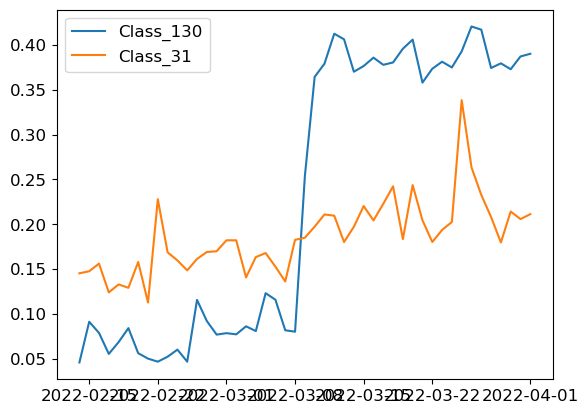

In [19]:
dates = logger_ref.get_logs().index
plt.plot(dates, class_drift_df.Class_130, label = "Class_130")
plt.plot(dates, class_drift_df.Class_31, label = "Class_31")
plt.legend()
plt.show()

In [29]:
print("Without retraining\n")
print(feature_drift_df.mean().sort_values(ascending=False))
print("\n\nRetraining\n")
print(ret_feature_drift_df.mean().sort_values(ascending=False))

Without retraining

DIR_4         0.501412
SIZE_4        0.463509
SIZE_5        0.345841
SIZE_3        0.326712
DIR_6         0.255425
                ...   
BYTES         0.008523
IPT_BIN1      0.008292
PSIZE_BIN8    0.007800
IPT_1         0.000000
DIR_1         0.000000
Length: 130, dtype: float64


Retraining

SIZE_1            0.084852
DIR_4             0.058716
SIZE_4            0.057559
PPI_ROUNDTRIPS    0.056313
PPI_LEN           0.052258
                    ...   
IPT_26            0.011658
PSIZE_BIN2_REV    0.011338
IPT_22            0.011231
IPT_1             0.000000
DIR_1             0.000000
Length: 130, dtype: float64


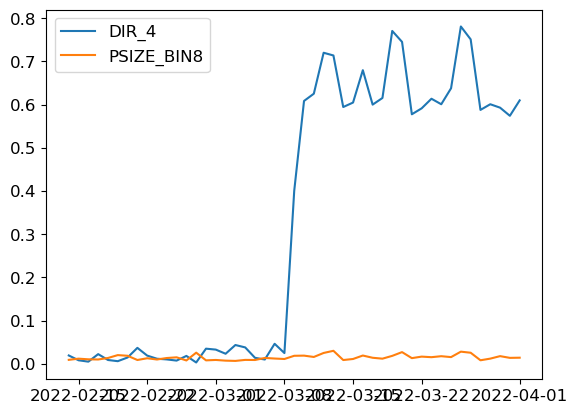

In [22]:
plt.plot(dates, feature_drift_df.DIR_4, label = "DIR_4")
plt.plot(dates, feature_drift_df.PSIZE_BIN8, label = "PSIZE_BIN8")
plt.legend()
plt.show()

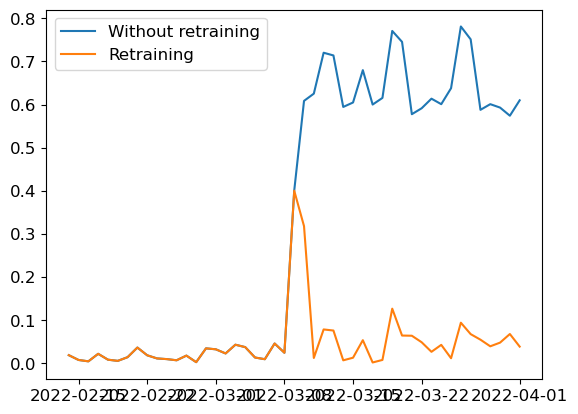

In [28]:
plt.plot(feature_drift_df.DIR_4, label = "Without retraining")
plt.plot(ret_feature_drift_df.DIR_4, label = "Retraining")
plt.legend()
plt.show()

In [29]:
print("Without retraining\n")
print(feature_drift_df.std().sort_values(ascending=False))
print("\n\nRetraining\n")
print(ret_feature_drift_df.std().sort_values(ascending=False))

Without retraining

DIR_4             0.315537
SIZE_4            0.309853
SIZE_3            0.226541
SIZE_5            0.205561
SIZE_9            0.101430
                    ...   
IPT_BIN1_REV      0.001603
PSIZE_BIN8_REV    0.001579
BYTES_REV         0.001574
IPT_1             0.000000
DIR_1             0.000000
Length: 130, dtype: float64


Retraining

SIZE_4          0.074553
DIR_4           0.072296
SIZE_3          0.053806
SIZE_5          0.048368
SIZE_1          0.040350
                  ...   
IPT_BIN1_REV    0.002421
PACKETS_REV     0.002404
BYTES_REV       0.002395
IPT_1           0.000000
DIR_1           0.000000
Length: 130, dtype: float64


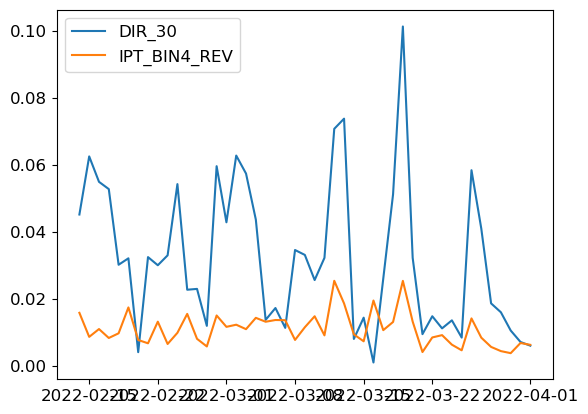

In [30]:
dates = logger_ref.get_logs().index
plt.plot(dates, ret_feature_drift_df.DIR_30, label = "DIR_30")
plt.plot(dates, ret_feature_drift_df.IPT_BIN4_REV, label = "IPT_BIN4_REV")
plt.legend()
plt.show()

In [31]:
print(feature_drift_df.std().sort_values(ascending=False))


DIR_4             0.315537
SIZE_4            0.309853
SIZE_3            0.226541
SIZE_5            0.205561
SIZE_9            0.101430
                    ...   
IPT_BIN1_REV      0.001603
PSIZE_BIN8_REV    0.001579
BYTES_REV         0.001574
IPT_1             0.000000
DIR_1             0.000000
Length: 130, dtype: float64


In [33]:
(ret_feature_drift_df>0.1).mean().sort_values(ascending=False)

SIZE_1      0.234043
DIR_4       0.063830
SIZE_9      0.042553
PPI_LEN     0.042553
SIZE_4      0.042553
              ...   
IPT_29      0.000000
IPT_28      0.000000
IPT_27      0.000000
IPT_26      0.000000
IPT_BIN2    0.000000
Length: 130, dtype: float64

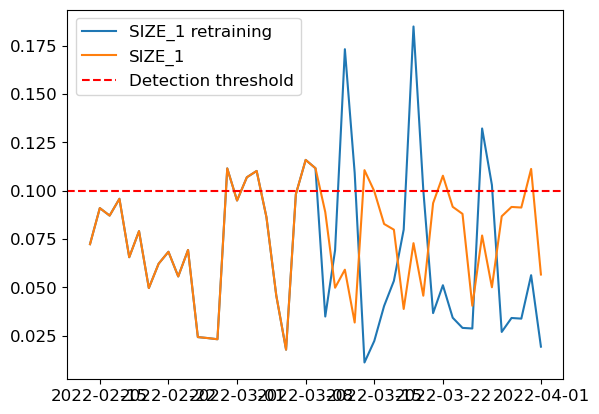

In [34]:
plt.plot(dates, ret_feature_drift_df.SIZE_1, label = "SIZE_1 retraining")
plt.plot(dates, feature_drift_df.SIZE_1, label = "SIZE_1")
plt.axhline(y = 0.1, color = 'r', linestyle = '--', label ="Detection threshold") 
plt.legend()
plt.show()